In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 7.4 MB/s 
     |████████████████████████████████| 46 kB 2.3 MB/s 
     |████████████████████████████████| 1.2 MB 56.8 MB/s 
     |████████████████████████████████| 188 kB 64.2 MB/s 
     |████████████████████████████████| 56 kB 5.7 MB/s 
     |████████████████████████████████| 51 kB 449 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

# Series de tiempo y redes neuronales 
 Hay varias maneras de usar redes neuronales para predecir series de tiempo. Nuestro objetivo será llegar a redes neuronales **recurrentes**.

 Vamos a hacer redes neuronales _"fully connected"_, pero si lo piensas bien, estamos usando la idea de las redes neuronales convolucionales.

In [3]:
import numpy as np 
import pandas as pd 
import fastai.tabular.all as ft
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [6]:
df = pd.read_csv("/content/daily-min-temperatures.csv", index_col="Date", parse_dates = True)

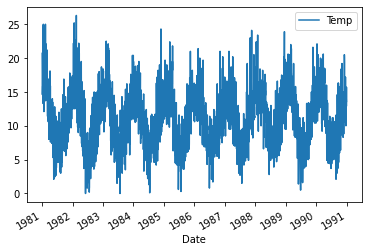

In [7]:
df.plot()

# ¿Cómo usar redes neuronales? 

1. Que la red tome exclusivamente la temperatura del día anterior pare predecir la temperatura del día siguiente

2. Convolucionales: Agregarle las últimas $k$ temperaturas para que pueda hacer la predicción 
3. Agregarle información del mes y del año 
4. Agreagarle por ejemplo EWMA
5. Agreagarle la desviación estándar y otra información 
6. ¿Por qué redes recurrentes? 

# Cargar datos

> Recordemos que fastai puede cargar datos "tabulares" (e.g. un dataframe en pandas) 


In [8]:
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


Queremos predecir la temperatura cada día basados en la temperatura anterior, así que debemos crear la columna "ultima_temp"

In [10]:
df["ultima_temp"] = df["Temp"].shift(1)

In [11]:
df.head()

,Temp,ultima_temp
Date,,
1981-01-01,20.7,NaN
1981-01-02,17.9,20.7
1981-01-03,18.8,17.9
1981-01-04,14.6,18.8
1981-01-05,15.8,14.6


In [30]:
def error_l1(df, colA, colB): 
  df = df.iloc[-365:]
  return np.mean(np.abs(df[colA]-df[colB]))

def error_rmse(df, colA, colB):
  df = df.iloc[-365:] 
  return np.sqrt(np.mean(np.square(df[colA]-df[colB])))

In [31]:
error_l1(df, 'Temp', 'ultima_temp')

2.0249315068493146

In [32]:
error_rmse(df, 'Temp', 'ultima_temp')

2.5824009217292243

In [15]:
df.dropna(inplace=True)

In [18]:
def cargar_datos(df): 
  X = ft.range_of(df)
  valid_cut = len(df) - 365
  src = ft.TabularPandas(df,
                         cont_names=list(df.columns[1:]), # Tomate estas columnas
                         y_names=['Temp'], # Para predecir esta
                        splits = (X[:valid_cut], X[valid_cut:])) # primeros para entrerar, últimos para validar
  return src.dataloaders(bs=1024)

In [19]:
dls = cargar_datos(df)

In [20]:
dls.one_batch()

(tensor([], size=(1024, 0), dtype=torch.int64), tensor([[11.2000],
         [ 4.2000],
         [16.3000],
         ...,
         [11.1000],
         [15.2000],
         [ 8.5000]]), tensor([[ 7.5000],
         [ 6.3000],
         [16.8000],
         ...,
         [ 4.7000],
         [14.1000],
         [ 1.4000]]))

La razón del tensor vacío, es que fastai divide en datos categóricos y datos contínuos. Sin embargo, ahora no tenemos ningún dato categórico, así que simplemente da vacio en los datos categóricos. 

In [26]:
def rmse_loss(pred, targ): 
  return torch.sqrt(F.mse_loss(pred, targ))

In [27]:
learn = ft.tabular_learner(dls, layers=[], metrics=[F.l1_loss, rmse_loss])

> Cuando tienes una red neuronal que solo tiene input y output, sin capaz intermedias (layers) eso es básicamente regresión lineal

In [28]:
learn.fit_one_cycle(25, 1e-1)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,119.411011,99.746979,9.395020,9.987341,00:00
1,119.618584,107.589256,9.790328,10.372524,00:00
2,119.189323,107.251617,9.794400,10.356236,00:00
3,117.436386,101.066772,9.527665,10.053197,00:00
4,114.717743,88.856163,8.957002,9.426354,00:00
5,110.600815,71.139557,8.023890,8.434427,00:00
6,104.964951,52.029598,6.790985,7.213154,00:00
7,97.912498,35.861462,5.418596,5.988444,00:00
8,90.101234,24.121454,4.200578,4.911360,00:00
9,82.053619,15.252042,3.218178,3.905386,00:00


Más o menos tiene el mismo error que la baseline

In [33]:
learn = ft.tabular_learner(dls, layers=[128, 128], metrics=[F.l1_loss, rmse_loss])

SuggestedLRs(valley=0.0030199517495930195)

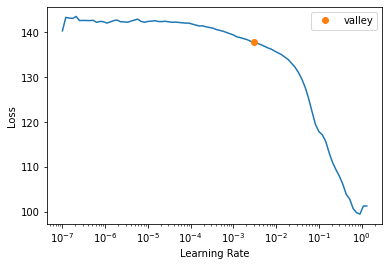

In [34]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(25, 3e-2)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,137.183640,148.589844,11.563702,12.189743,00:00
1,133.649399,103.200600,9.675129,10.158770,00:00
2,131.487946,83.703323,8.770566,9.148952,00:00
3,128.826706,72.634689,8.162223,8.522598,00:00
4,124.548050,63.241009,7.570801,7.952421,00:00
5,116.393265,46.941151,6.295391,6.851361,00:00
6,102.586349,12.436832,2.840730,3.526589,00:00
7,88.317024,19.839996,3.784734,4.454211,00:00
8,78.962814,18.470236,3.703346,4.297701,00:00
9,70.455139,6.481621,2.016283,2.545903,00:00


Un poco mejor, pero no mucho. La razón: nada más le dimos la temperatura anterior. Cómo le va a hacer para hacerlo mejor? 

# Redes convolucionales

Si en vez de darle la temperatura anterior le damos $k$ anteriores. ¿Mejorara? 

In [36]:
df = pd.read_csv("/content/daily-min-temperatures.csv", index_col = 'Date', parse_dates=True)

In [37]:
k = 10 
for i in range(1, k+1): 
  df[f'ultima_{i}'] = df['Temp'].shift(i)

In [38]:
df

,Temp,ultima_1,ultima_2,ultima_3,ultima_4,ultima_5,ultima_6,ultima_7,ultima_8,ultima_9,ultima_10
Date,,,,,,,,,,,
1981-01-01,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,17.9,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-03,18.8,17.9,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-04,14.6,18.8,17.9,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-05,15.8,14.6,18.8,17.9,20.7,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1990-12-27,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2,13.9
1990-12-28,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2
1990-12-29,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7


In [39]:
df.dropna(inplace=True)

In [40]:
dls = cargar_datos(df)

In [43]:
learn = ft.tabular_learner(dls, layers=[256, 128], metrics=[rmse_loss, F.l1_loss])

In [44]:
learn.fit_one_cycle(50, 3e-2)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,6.716267,5.813984,1.908991,2.411220,00:00
1,6.644068,5.811386,1.910565,2.410681,00:00
2,6.612760,5.807263,1.910819,2.409826,00:00
3,6.613541,5.778076,1.902535,2.403763,00:00
4,6.591526,5.791072,1.899684,2.406465,00:00
5,6.612793,5.823544,1.914969,2.413202,00:00
6,6.614173,5.798828,1.900912,2.408076,00:00
7,6.625362,5.886679,1.918192,2.426248,00:00
8,6.637168,5.792759,1.902601,2.406815,00:00
9,6.635448,5.904768,1.931525,2.429973,00:00


Mejor...

# Modelo 

Estamos usando un red neuronal "fully connected"

In [45]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=1, out_features=128, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=128, out_features=128, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

- embeds es vacio porque no tenemos variables categóricas
- emb_drop es el embedding dropout. Podemos agregarle si queremos
- bn_cont es la capa batchnorm que le aplicamos a las variables continuas. En este caso solo tenemos una variable
- layers son las capas que le dijimos

Podemos modificarla como normalmente hacemos, por ejemplo: 

In [46]:
leanr.model.layers[0][2] = nn.LeakyReLU(inplace=True)

In [47]:
learn.model.layers[1][2] = nn.LeakyReLU(inplace=True)

In [50]:
learn = ft.tabular_learner(dls, layers=[256, 128], metrics=[rmse_loss, F.l1_loss])

In [51]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=10, out_features=256, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=256, out_features=128, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [52]:
learn.fit_one_cycle(50, 3e-2)

epoch,train_loss,valid_loss,rmse_loss,l1_loss,time
0,135.981552,98.326416,9.915967,9.359979,00:00
1,133.415344,71.251091,8.441036,7.971455,00:00
2,131.924103,67.747292,8.230874,7.843600,00:00
3,130.848618,82.878334,9.103754,8.780034,00:00
4,129.567429,86.865479,9.320165,9.035064,00:00
5,127.788750,75.006546,8.660632,8.285307,00:00
6,125.355019,70.624352,8.403830,7.976893,00:00
7,121.190590,67.324615,8.205158,7.840672,00:00
8,113.689514,45.842434,6.770704,6.115048,00:00
9,102.240829,21.417395,4.627893,3.821303,00:00
